参考资料：
+ https://blog.csdn.net/shebao3333/article/details/78808066 - 好
+ https://blog.csdn.net/xdzhangzhenhao/article/details/81147838
+ 

In [1]:
import os
import numpy as np 
import pandas as pd 
from cv2 import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt 


ROOT_DIR = os.getcwd()
TRAIN_DATA = os.path.join(ROOT_DIR, 'digits_data')
TEST_DATA_CAP = os.path.join(ROOT_DIR, 'captcha_test_data')
TEST_DATA_CHAR = os.path.join(ROOT_DIR, 'character_test_data')

下面的一个cell的代码是分割captha

In [2]:
# 为了方便图片直接显示在jupyter中，cv的imshow不能直接在jupyter中显示
# 为了用matplotlib显示（ 不能用plt.show()，要用plt.imshow() ）
# 由于CV的通道是BGR顺序，而matpotlib是 RGB顺序，这里要做通道转换
# 方法一
def bgr2rgb_v2(img):
    # 用cv自带的分割和合并函数
    B,G,R = cv.split(img)
    return cv.merge([R,G,B])
# 方法二
def bgr2rgb(img):
    # 直接用python切片特性，[start: end: step], 这里start end为空，则默认遍历全部，step为-1则倒序遍历
    return img[:, :, ::-1]

def genNeedImg(img_path, img_type='binary', binary_therhold=127, 
               binary_reverse=False, size=None, save=False, path='./'):
    '''
    用于生成指定大小的灰度图或二值图, img_path为图像路径
    type为标志转换类型，默认为binary，可选的值为binary或gray
    binary_therhold为二值图划分阈值，默认127（即大于127的像素设置为255，否则置0）
    binary_reverse默认为False，True时黑白颠倒（即大于127的像素设置为0，否则置255）
    size为tuple类型，用于指定生成图像的尺寸, 如：(512,512)，默认为None表示输出原图像尺寸
    save为保存标志，默认为False，为true时将生成的图保存到path(默认为当前文件夹)
    '''
    img_raw = cv.imread(img_path)
    if size != None: # 调整图像尺寸
        img_raw= cv.resize(img_raw,size)
    img_gray = cv.cvtColor(img_raw,cv.COLOR_RGB2GRAY) # 转换颜色空间为灰度
    # Add some extra padding around the image
    # img_gray = cv.copyMakeBorder(img_gray, 8, 8, 8, 8, cv.BORDER_REPLICATE)
    img_name = img_path[9:].split('.')[0] # 获取图像原始名称
    if img_type == 'gray': # 生成灰度图
        if save:
            cv.imwrite(os.path.join(path,'{}_gray.bmp'.format(img_name)),img_gray)
            print('Gray image saved at {}'.format(os.path.join(path,'{}_gray.bmp'.format(img_name))))
        else:
            print('Gray image generated!')
            return img_gray
    else: # 生成二值图
        if binary_reverse:
            ret, img_binary = cv.threshold(img_gray,binary_therhold,255,cv.THRESH_BINARY_INV) #反二进制阈值化
        else:
            ret, img_binary = cv.threshold(img_gray,binary_therhold,255,cv.THRESH_BINARY)# 二进制阈值化
        if save:
            cv.imwrite(os.path.join(path,'{}_binary.bmp'.format(img_name)),img_binary)
            print('threshold:{}'.format(ret)) # 输出转换阈值
            print('Binary image savd at {}'.format(os.path.join(path,'{}_binary.bmp'.format(img_name))))
        else:
            print('Binary image generated!')
            print('threshold:{}'.format(ret)) # 输出转换阈值
            return img_binary

def captcha_character_detach(captcha_img_path, save_flag=False, characters_save_path='./', captcha_len=4):
    '''
    这个函数是用于获取训练集时用来分割captcha的，所以会记录验证码名字
    传入的验证码必须带有标签，验证码命名就是标签名，如 1415.png
    '''
    captcha_img_basename = os.path.basename(captcha_img_path) # 从路径中提取带后缀文件名，如 '0415.png'
    captcha_text = os.path.splitext(captcha_img_basename)[0] # ['0415', 'png']
    img_gray = cv.imread(captcha_img_path, cv.IMREAD_GRAYSCALE) # 灰度图读入
    img_binary = genNeedImg(captcha_img_path, img_type='binary', binary_therhold=127, binary_reverse=True) # 直接调用genNeedImg生成二值图
    contours, hierarchy = cv.findContours(img_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) # 划分字符轮廓
    # 由于直接划分的轮廓太多了（我换了字体后好像不会划分很多），这里考虑记录每个每个轮廓的数据，然后取 wxh （长x宽，即面积）的top4
    boundings = [cv.boundingRect(contour) for contour in contours] # 获取每个轮廓的信息，(x,y,width,height) x,y为轮廓最左上角坐标
    boundings.sort(key=lambda tuple_x: tuple_x[2]*tuple_x[3], reverse=True) # lamdba传入的就是计算每个轮廓的面积，然后按面积大小降序排序
    if len(boundings) < captcha_len: # 获取到的轮廓小于4，则说明没有把4个字符都区分开来
        print('Bondings less then 4, captcha discarded!')
        return # 直接结束，丢弃这个验证码样本
    '''
    # 下面开始画矩形分割框，这部分其实用不到，只是为了调试看画的样子
    # -----------------------------------------------------------------------------------------
    temp_img = cv.imread(captcha_img_path, cv.IMREAD_UNCHANGED) # 以原始格式读入图片
    temp_img = bgr2rgb(temp_img) # 通道转换
    for bounding in boundings[:4]: # 取面积最大的前4个轮廓
        x, y, width, height = bounding
        img_addBox = cv.rectangle(temp_img, (x,y), (x + width, y + height), (0, 255, 0), 1)
    plt.imshow(img_addBox, cmap='gray')
    # ------------------------------------------------------------------------------------------
    '''
    boundings_save = sorted(boundings[:captcha_len], key=lambda tuple_x: tuple_x[0]) # 按轮廓的x坐标大小排序，tuple_x=(x,y,width,height) 
    character_splited = []
    for character_bounding, character_text in zip(boundings_save, captcha_text):
        x, y, width, height = character_bounding
        margin = 2 # 提取单个字符的时候，在获取的轮廓拓宽margin个像素，因为findContours()的轮廓可能很紧凑
        character_img = img_gray[y - margin:y + height + margin, x - margin:x + width + margin]
        if save_flag:
            if not os.path.exists(characters_save_path): # 如果要保存的路径不存在就创建该路径目录
                os.makedirs(characters_save_path)
            character_path = os.path.join(characters_save_path, '{}_0.png'.format(character_text))
            i = 0
            while True:
                i += 1
                if os.path.exists(character_path): # 该字符已经有样本，则在正确标签后面加_i, i标记重复次数
                    character_path = os.path.join(characters_save_path, '{}_{}.png'.format(character_text, i))
                else: # 不存在重名路径，则跳出
                    break
            cv.imwrite(character_path, character_img)
            print('Character detached from captcha, character has been saved at {}'.format(characters_save_path))
        character_splited.append(character_img)
    return character_splited

In [3]:
def captcha_char_detach(captcha_img_path, captcha_len=4):
    '''
    本函数在captcha_character_detach基础上，去除了识别验证码标签和保存分割的字符两个功能
    这个函数是用于单纯分割captcha的，用于验证码识别时分割字符用
    传入的验证码为需要检测识别的对象，可以不带标签
    '''
    img_gray = cv.imread(captcha_img_path, cv.IMREAD_GRAYSCALE) # 灰度图读入
    img_binary = genNeedImg(captcha_img_path, img_type='binary', binary_therhold=127, 
                            binary_reverse=True) # 直接调用genNeedImg生成二值图
    contours, hierarchy = cv.findContours(img_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) # 划分字符轮廓
    # 由于直接划分的轮廓太多了（我换了字体后好像不会划分很多），这里考虑记录每个每个轮廓的数据，然后取 wxh （长x宽，即面积）的top4
    boundings = [cv.boundingRect(contour) for contour in contours] # 获取每个轮廓的信息，(x,y,width,height) x,y为轮廓最左上角坐标
    boundings.sort(key=lambda tuple_x: tuple_x[2]*tuple_x[3], reverse=True) # lamdba传入的就是计算每个轮廓的面积，然后按面积大小降序排序
    if len(boundings) < captcha_len: # 获取到的轮廓小于4，则说明没有把4个字符都区分开来
        print('Bondings less then {}, captcha discarded!'.format(captcha_len))
        return # 直接结束，丢弃这个验证码样本
    boundings_save = sorted(boundings[:captcha_len], key=lambda tuple_x: tuple_x[0]) # 按轮廓的x坐标大小排序，tuple_x=(x,y,width,height) 
    character_splited = []
    for character_bounding in boundings_save:
        x, y, width, height = character_bounding
        margin = 2 # 提取单个字符的时候，在获取的轮廓拓宽margin个像素，因为findContours()的轮廓可能很紧凑
        character_img = img_gray[y - margin:y + height + margin, x - margin:x + width + margin]
        character_splited.append(character_img)
    return character_splited # 返回的是灰度图

In [4]:
def gen_data_set(captcha_imgs_folder, binary=False, binary_reverse=True):
    '''
    此函数用于创建 样本集和对应标签集合,返回的数据集是np.array类型
    binary: 用于控制是否生成二值样本
    '''
    target_imgs = [ os.path.join(captcha_imgs_folder, img_name) 
                    for img_name in os.listdir(captcha_imgs_folder) if img_name != '.DS_Store' ] 
    target_imgs.sort() # 升序，注意不能 listA = listA.sort(), sort没有返回值
    data_set, label_set = [], []
    # 发现一个问题，如果先变成二值图，再进行resize会导致出现非0、255的像素，见上一个cell测试
    # 故这里再genNeedImg时候，指定20x20尺寸
    for captcha in target_imgs:
        if binary:
            img = genNeedImg(captcha, size=(20,20), binary_reverse=binary_reverse) # 生成20x20大小的二值图
        else:
            img = cv.imread(captcha, cv.IMREAD_GRAYSCALE) # 以灰度图读入验证码/单个字符的图
            img = cv.resize(img, (20,20)) # 调整尺寸到20x20
        img = img.reshape(400,)  # reshape成一维数组（sklearn用kNN时需要的格式）
        data_set.append(img)
        label_set.append(os.path.basename(captcha)[0])
    return np.array(data_set), np.array(label_set)

data_set, label_set = gen_data_set(TRAIN_DATA, binary=True)
# label_set
# plt.imshow(data_set[8])
# data_set[0]

Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0


## 下面用sklearn的kNN工具来做训练和预测

In [5]:
from sklearn.neighbors import KNeighborsClassifier

kNN_classifier = KNeighborsClassifier(n_neighbors=3)
kNN_classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

### 看了一下https://blog.csdn.net/xdzhangzhenhao/article/details/81147838
### 测试发现，sklearn中的kNN需要的数据的shape必须是 (n,) 也就是一维数组，所以gen_data_set()中会有规整化数据的操作

In [6]:
X_train, y_train = data_set, label_set
kNN_classifier.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [7]:
X_test, y_test = gen_data_set(TEST_DATA_CHAR, binary=True)
predicted_result = kNN_classifier.predict(X_test)
predicted_result = pd.Series(predicted_result)
predicted_result

Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0


0      0
1      0
2      0
3      0
4      0
      ..
391    9
392    9
393    9
394    9
395    9
Length: 396, dtype: object

In [8]:
actual_result = pd.Series(y_test)
actual_result

0      0
1      0
2      0
3      0
4      0
      ..
391    9
392    9
393    9
394    9
395    9
Length: 396, dtype: object

In [9]:
def prediction_accuracy(predicted_results, actual_results):
    '''
    预测结果的正确率计算
    predicted_results, actual_results都需要是pandas的Series对象
    '''
    compare = predicted_results == actual_results # 返回一个Series对象
    if compare.value_counts().loc[False] == len(actual_results):
        return 0
    return compare.value_counts().loc[True] /  compare.count() # 预测和实际值匹配的占所有的比例

In [10]:
prediction_accuracy(predicted_result, actual_result)

0.9848484848484849

### 下面我尝试自己实现一下kNN算法

In [11]:
def judger(k_prediction):
    '''
    判决器，k_prediction是有权重的，索引最小代表该预测值和实际值相似度最大
    但是，可能出现如：k=5，k_prediction=（7, 1, 2, 2, 2），这样的情况，我定预测结果为2
    也就是，重复预测值个数 >= 预测值总数的2/3，则取该重复预测值
    '''
    k = len(k_prediction)
    tmp = list(k_prediction)
    [tmp.remove(i) for i in list(set(tmp))]
    duplication = set(tmp) # 找出预测值中重复元素
    if len(duplication) == 0:
        return k_prediction[0] 
    if k_prediction[0] not in duplication: # 最接近的预测值不再重复出现的
        top_dupli = tmp[ min([ tmp.index(d) for d in duplication]) ]# 找出重复预测值中接近程度最高的值
        count = sum([ 1 for i in k_prediction if i==top_dupli]) # 统计较高相似度的重复预测值出现次数
        if count >= int(2/3 * k): # 如果较高相似度的重复预测值出现次数 >= 预测值总数的2/3，则取该预测值
            return top_dupli    
    return k_prediction[0]

# judger( (5,2,2,3,3,3) )

解释一下`judger()`函数：    
因为kNN计算的是与目标样本最接近的k个预测值，在`RG_kNN_classifier()`中，预测结果是一个tuple      
结构为 $ (p_1, p_2, \cdots, p_k)$，其中，$p_1$最接近目标样本的预测（距离最小），因此其预测价值应该最大  
所以，为了给出最后的预测值，我写了该`judger()`判决函数。
判决流程为：
+ 从 $ k\_prediction = (p_1, p_2, \cdots, p_k)$ 中找出重复出现的预测值，保存到duplication中
+ 如果 duplication 为空(即不存在重复预测值) 或者 $p_1 \in duplication$ ，则直接返回 预测值 $p_1$，结束流程，否则继续接下来的流程
+ 找出duplication中预测价值最大（也就是序号最小）的值 top_dupli
+ 统计 top_dupli 出现的次数，记作 count
+ 如果 $ count >= [ 2/3 \cdot k]$，则返回 top_dupli，否则依旧返回 $p_1$ (其中[]为取整)
至于为啥是 2/3， 是我设置的值，可以自行调整     
举例：
+ (3, 2, 1, 1, 1) 返回 1
+ (1, 2, 3, 4) 返回 1
+ (1, 2, 1, 1, 2) 返回 1

In [12]:
def RG_kNN_classifier(feature_set_train, label_set_train, feature_set_test, k=3):
    '''
    所有的feature集合中的图像矩阵需要reshape成一维数组（传入前特征工程需要把图像先resize成20x20再reshape成（400,））
    feature_set_train, label_set_train, feature_set_test都必须是np.array
    '''
    label_set_Kpredict, topK_list = [],[] # 增加topK_list记录最接近的图像编号
    for test_feature in feature_set_test:
        distances = []
        for train_feature in feature_set_train:
            distances.append(
                np.sqrt(np.sum(np.square(test_feature - train_feature)))
            )
        # topK = np.argsort(distances)[-k:][::-1] # [-k:]是提取最后k个（因为argsort是升序排序）,[::-1]则是将其反序
        topK = np.argsort(distances)[:k] # ummmm, 我感觉我昨天写代码脑袋写坏了，应该取距离最小的，我上面那句取了距离最大的k个
        if k != 1:
            label_set_Kpredict.append(
                tuple(label_set_train[list(topK)]) # 保存最接近的k个预测值
            )
            topK_list.append(tuple(topK))
        else:
            label_set_Kpredict.append(
                tuple(label_set_train[list(topK)])[0] # 保存最接近的k个预测值
            )
            topK_list.append(tuple(topK))
    if k==1:
        return label_set_Kpredict, topK_list
    else:
        # k个最接近的值，做一个投票器，利用投票器选出最终预测值
        label_set_single = [ judger(labels) for labels in label_set_Kpredict]
        return label_set_single, label_set_Kpredict, topK_list

In [13]:
predicted_result_0 = pd.Series(RG_kNN_classifier(X_train,y_train,X_test, k=3)[0])
predicted_result_0
# t = RG_kNN_classifier(X_train,y_train,X_test, k=3)

0      0
1      0
2      0
3      0
4      0
      ..
391    9
392    9
393    9
394    9
395    9
Length: 396, dtype: object

In [14]:
# 我自己写的kNN识别 每个单个字符 的识别率
prediction_accuracy(predicted_result_0 , actual_result)

0.9924242424242424

### 以上是直接识别单个字符，下面开始写，送入一个4个字符的验证码，进行整体识别

In [15]:
# captcha_path = {
#     'text': captcha_name,
#     'path': os.path.join(TEST_DATA_CAP, captcha_name)
#     for captcha_name in os.listdir(TEST_DATA_CAP)
# } # 试了试，python字典不能像list一样快速遍历生成
captcha_paths = [ os.path.join(TEST_DATA_CAP, captcha_name) for captcha_name in os.listdir(TEST_DATA_CAP)] 
captcha_paths.sort()
# captcha_path

In [23]:
def captcha_recognition(captcha_path, X_train, y_train, captcha_len=4, k=3):
    '''
    本函数用于识别传入的验证码，目前只写了识别4位的，后期可以改识别n位
    X_train: 验证码单个字符的特征训练集
    y_train: 验证码单个字符的标签训练集
    '''
    character_splited = captcha_char_detach(captcha_path, captcha_len=captcha_len) # 返回灰度图
    binary_chars = [] # 存储二值化后的单个字符
    for character in character_splited:
        character = cv.resize(character, (20,20)) # 先归一成20x20大小
        ret, char_binary = cv.threshold(character,127,255,cv.THRESH_BINARY_INV) # 再反二进制阈值化，生成二值图
        binary_chars.append( char_binary.reshape(400,) )# 然后变成一维数组，这三步顺序不能有错
    return ''.join(RG_kNN_classifier(X_train, y_train, binary_chars, k=k)[0])

i = 2
captcha_recognition(captcha_paths[i], X_train, y_train, captcha_len=4, k=3)

Binary image generated!
threshold:127.0


'0186'

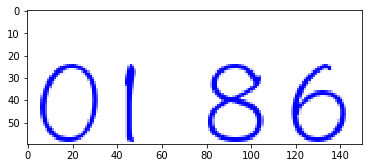

In [24]:
img = cv.imread(captcha_paths[i])
plt.imshow(img)

In [18]:
captcha_text_predict = [ 
    captcha_recognition(cap, X_train, y_train, captcha_len=4, k=3)
    for cap in captcha_paths
]

Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0
Binary image generated!
threshold:127.0


In [19]:
captcha_text_actual = [ # 获取测试集的实际标签
    os.path.splitext(os.path.basename(cap))[0]
    for cap in captcha_paths
]

In [20]:
# 计算 验证码 的预测准确率（识别率）
captcha_text_predict = pd.Series(captcha_text_predict)
captcha_text_actual = pd.Series(captcha_text_actual)
prediction_accuracy(captcha_text_predict, captcha_text_actual)

0.9797979797979798